# Groceries Nutriscore Prediction (Analysis and Modelization Part)

The "Public Health France" agency has launched a call for projects to find innovative ideas for food-related applications. You want to participate and propose an application idea.

### About the Dataset

The Open Food Fact dataset is available on the official website. The variables are defined at this address.

The dataset has as datapoint each product (1443749 products) and for each, we have 181 columns which are separated in four sections :

- General information on the product datasheet: name, date of modification, etc.
- A set of tags: product category, location, origin, etc.
- The ingredients that make up the products and their possible additives.
- Nutritional information: quantity in grams of a nutrient per 100 grams of the product.
- Nutriscore : Also known as the 5-color system, is a nutrition labeling system based on a logo with five values from A to E and from green to red, established according to the nutritional value of a food product. It is implemented by the French government in 2016 as part of the law to modernize the health system.

How is the nutriscore awarded?

The score takes into account for 100 grams of product, the content :

- Nutrients and foods to be promoted (fibers, proteins, fruits and vegetables),
- Nutrients to be limited (energy, saturated fatty acids, sugars, salt).
- After calculation, the score obtained by a product is used to assign it a letter (A to D) and a color.

### About the idea

It is not yet mandatory for the manufacturers to display the nutriscore on each grocery product, moreover the dataset being supplied by individuals, the nutriscore is not always noted and the information filled in are often restricted to the barcode and the name of the products and to the nutrients that appears on the back of the product package.

Therefore around 50% of the products of the dataset does not have a nutriscore information.

After a cleaning phase we noticed that it was not possible to calculate directly the Nutriscore.

Objectives of this analysis notebook :

- EDA (Univariate, Multivariate and Correlation Analysis) to get some insights.
- Modelizatiom of the nutriscore in order to predict it.


In [2]:
import json
import datetime
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

plt.style.use('ggplot')
from matplotlib.pyplot import figure
%matplotlib inline
pd.options.mode.chained_assignment = None

## 1. Data Import

In [3]:
df = pd.read_csv('openfoodfacts_products_cleaned.csv', low_memory=False)

## 2. Data Description
##### Show data header


In [3]:
df.head(3)

,code,product_name,main_category_en,pnns_groups_1,pnns_groups_2,nutriscore_score,nutriscore_grade,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
0,0000000000017,vitória crackers,NaN,unknown,unknown,NaN,NaN,1569.0,7.0,3.08,70.1,15.0,0.0,7.8,1.40
1,0000000000100,moutarde au moût de raisin,Mustards,Fat and sauces,Dressings and sauces,18.0,d,936.0,8.2,2.20,29.0,22.0,0.0,5.1,4.60
2,0000000000123,sauce sweety chili 0%,NaN,unknown,unknown,NaN,NaN,88.0,0.0,0.00,4.8,0.4,0.0,0.2,2.04


##### Show data info


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1045457 entries, 0 to 1045456
Data columns (total 15 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   code                1045457 non-null  object 
 1   product_name        1045455 non-null  object 
 2   main_category_en    593670 non-null   object 
 3   pnns_groups_1       1043571 non-null  object 
 4   pnns_groups_2       1045457 non-null  object 
 5   nutriscore_score    536478 non-null   float64
 6   nutriscore_grade    536478 non-null   object 
 7   energy_100g         1044885 non-null  float64
 8   fat_100g            1042722 non-null  float64
 9   saturated-fat_100g  1014514 non-null  float64
 10  carbohydrates_100g  1042626 non-null  float64
 11  sugars_100g         1036956 non-null  float64
 12  fiber_100g          1045457 non-null  float64
 13  proteins_100g       1044779 non-null  float64
 14  salt_100g           1043815 non-null  float64
dtypes: float64(9), 

##### Fix data types


In [4]:
df.product_name = df.product_name.astype('category')
df.main_category_en = df.main_category_en.astype('category')
df.pnns_groups_1 = df.pnns_groups_1.astype('category')
df.pnns_groups_2 = df.pnns_groups_2.astype('category')
df.nutriscore_grade = df.nutriscore_grade.astype('category')

Now, let's check our new data types and column names:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1045457 entries, 0 to 1045456
Data columns (total 15 columns):
 #   Column              Non-Null Count    Dtype   
---  ------              --------------    -----   
 0   code                1045457 non-null  object  
 1   product_name        1045455 non-null  category
 2   main_category_en    593670 non-null   category
 3   pnns_groups_1       1043571 non-null  category
 4   pnns_groups_2       1045457 non-null  category
 5   nutriscore_score    536478 non-null   float64 
 6   nutriscore_grade    536478 non-null   category
 7   energy_100g         1044885 non-null  float64 
 8   fat_100g            1042722 non-null  float64 
 9   saturated-fat_100g  1014514 non-null  float64 
 10  carbohydrates_100g  1042626 non-null  float64 
 11  sugars_100g         1036956 non-null  float64 
 12  fiber_100g          1045457 non-null  float64 
 13  proteins_100g       1044779 non-null  float64 
 14  salt_100g           1043815 non-null  float64 
dty

##### Show statistical analysis of our data set
Let's show min, max, mean, std, and count of each column in the dataset.

In [7]:
df.describe()

,nutriscore_score,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
count,536478.000000,1.044885e+06,1.042722e+06,1.014514e+06,1.042626e+06,1.036956e+06,1.045457e+06,1.044779e+06,1.043815e+06
mean,8.973164,1.095151e+03,1.264644e+01,4.983637e+00,2.742256e+01,1.327794e+01,8.781615e-01,8.500612e+00,1.219405e+00
std,8.908539,7.478307e+02,1.565022e+01,7.302543e+00,2.746102e+01,1.918074e+01,2.549140e+00,9.633584e+00,3.845868e+00
min,-15.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000,4.230000e+02,7.000000e-01,1.000000e-01,3.570000e+00,7.000000e-01,0.000000e+00,1.400000e+00,8.000000e-02
50%,10.000000,1.046000e+03,6.700000e+00,1.800000e+00,1.462000e+01,3.700000e+00,0.000000e+00,5.810000e+00,5.750000e-01
75%,16.000000,1.632000e+03,2.000000e+01,7.000000e+00,5.200000e+01,1.846000e+01,1.000000e-01,1.200000e+01,1.392500e+00
max,40.000000,3.700000e+03,9.997000e+01,9.990000e+01,9.999000e+01,1.000000e+02,9.550000e+01,9.990000e+01,9.999000e+01


##### Show if there are missing datapoints¶


In [8]:
obj = df.isna().mean().round(4) * 100
for key,value in obj.iteritems():
    print(key,",",value)

code , 0.0
product_name , 0.0
main_category_en , 43.21
pnns_groups_1 , 0.18
pnns_groups_2 , 0.0
nutriscore_score , 48.68
nutriscore_grade , 48.68
energy_100g , 0.05
fat_100g , 0.26
saturated-fat_100g , 2.96
carbohydrates_100g , 0.27
sugars_100g , 0.8099999999999999
fiber_100g , 0.0
proteins_100g , 0.06
salt_100g , 0.16


[Text(33.0, 0.5, 'Data Points'),
 Text(0.5, 14.09375, 'Columns'),
 Text(0.5, 1, 'Missing Data')]

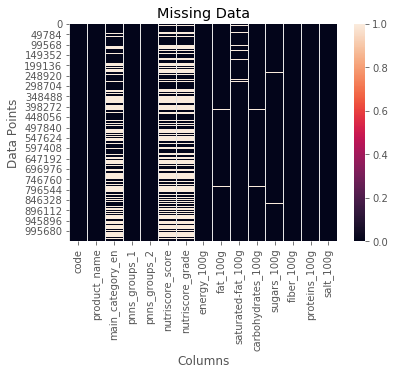

In [9]:
sns.heatmap(df.isnull()).set(title = 'Missing Data', xlabel = 'Columns', ylabel = 'Data Points')

We can see from above that we have some missing data points, but it is not extensive and it mainly concerns the categorical features.

Later in the project we will deal with these missing data points, in the data cleaning section.

In [5]:
df['energy_100g'] = df['energy_100g'].fillna(df.groupby(['pnns_groups_1'])['energy_100g'].transform('mean'))

df['fat_100g'] = df['fat_100g'].fillna(df.groupby(['pnns_groups_1'])['fat_100g'].transform('mean'))

df['saturated-fat_100g'] = df['saturated-fat_100g'].fillna(df.groupby(['pnns_groups_1'])['saturated-fat_100g'].transform('mean'))

df['carbohydrates_100g'] = df['carbohydrates_100g'].fillna(df.groupby(['pnns_groups_1'])['carbohydrates_100g'].transform('mean'))

df['sugars_100g'] = df['sugars_100g'].fillna(df.groupby(['pnns_groups_1'])['sugars_100g'].transform('mean'))

df['proteins_100g'] = df['proteins_100g'].fillna(df.groupby(['pnns_groups_1'])['proteins_100g'].transform('mean'))

df['salt_100g'] = df['salt_100g'].fillna(df.groupby(['pnns_groups_1'])['salt_100g'].transform('mean'))



In [6]:
df = df.dropna(how='any', subset=['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g'])

In [12]:
obj = df.isna().mean().round(4) * 100
for key,value in obj.iteritems():
    print(key,",",value)

code , 0.0
product_name , 0.0
main_category_en , 43.22
pnns_groups_1 , 0.16
pnns_groups_2 , 0.0
nutriscore_score , 48.67
nutriscore_grade , 48.67
energy_100g , 0.0
fat_100g , 0.0
saturated-fat_100g , 0.0
carbohydrates_100g , 0.0
sugars_100g , 0.0
fiber_100g , 0.0
proteins_100g , 0.0
salt_100g , 0.0


## 2. EDA
### 2.1 Univariate Analysis: Numerical Variable

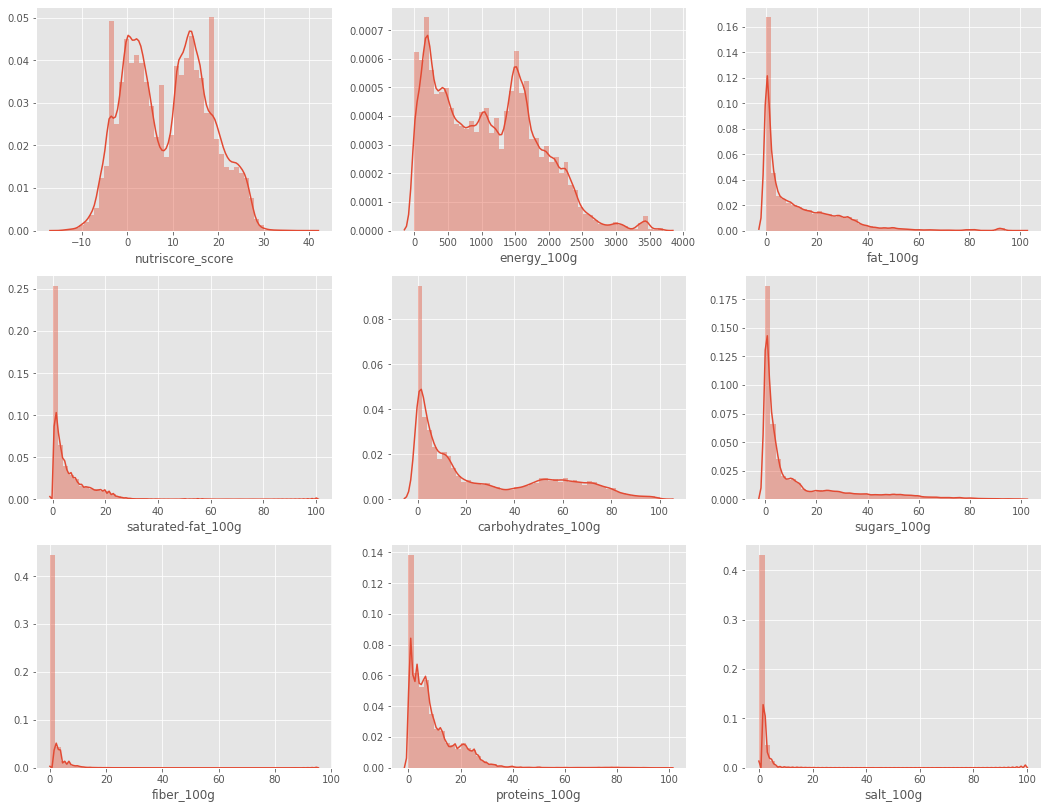

In [13]:
def plot_multiple_histograms(df, cols):
    matplotlib.rcParams['figure.figsize'] = (18,14)
    num_plots = len(cols)
    num_cols = math.ceil(np.sqrt(num_plots))
    num_rows = math.ceil(num_plots/num_cols)
        
    fig, axs = plt.subplots(num_rows, num_cols)
    
    for ind, col in enumerate(cols):
        i = math.floor(ind/num_cols)
        j = ind - i*num_cols
            
        if num_rows == 1:
            if num_cols == 1:
                sns.distplot(df[col], kde=True, ax=axs)
            else:
                sns.distplot(df[col], kde=True, ax=axs[j])
        else:
            sns.distplot(df[col], kde=True, ax=axs[i, j])

            
plot_multiple_histograms(df, ['nutriscore_score', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g'])

matplotlib.rcParams["figure.figsize"] = [6.4, 4.8]


### 2.2 Univariate Analysis: Categorical Variables


[Text(0.5, 1.0, 'Proportion of Nutriscore grade')]

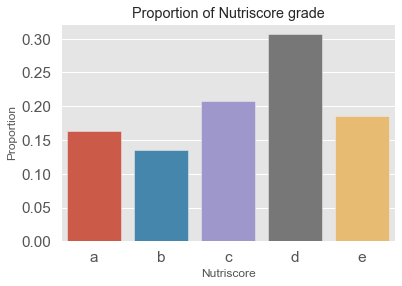

In [187]:
x, y = "Nutriscore", "Proportion"

prop_df = (df["nutriscore_grade"]
           .value_counts(normalize=True)
           .rename_axis(x)
           .rename(y)
           .reset_index())

sns.barplot(x=x, y=y, data=prop_df).set(title = 'Proportion of Nutriscore grade')

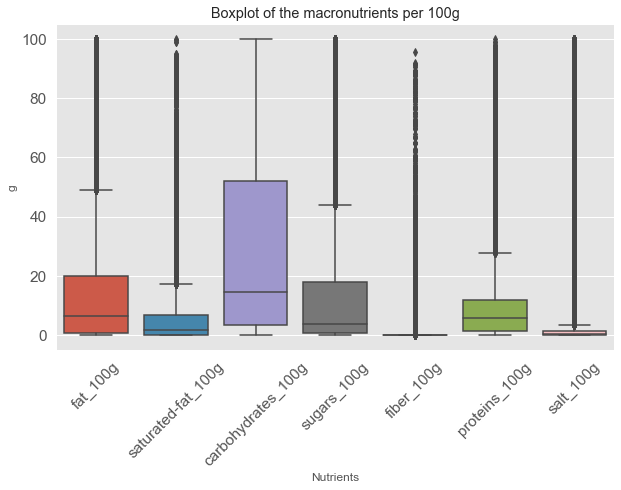

In [200]:
df_100g = df[["fat_100g", "saturated-fat_100g", "carbohydrates_100g", "sugars_100g", "fiber_100g", "proteins_100g", "salt_100g"]]
fig = plt.figure(figsize=(10, 6))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(df_100g), dodge =False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.set(title = 'Boxplot of the macronutrients per 100g', xlabel = 'Nutrients', ylabel = 'g')

plt.show()

### 2.3 Multivariate Analysis: Categorical vs Numerical Variables 

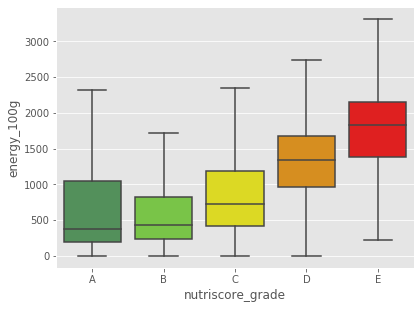

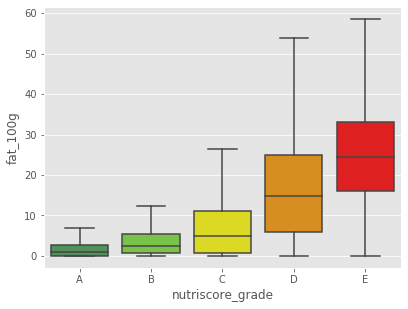

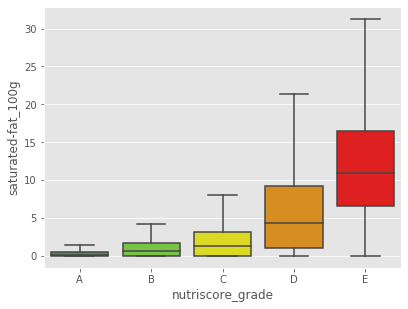

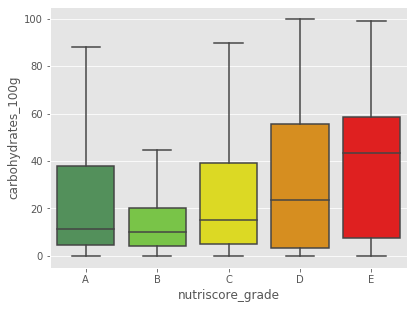

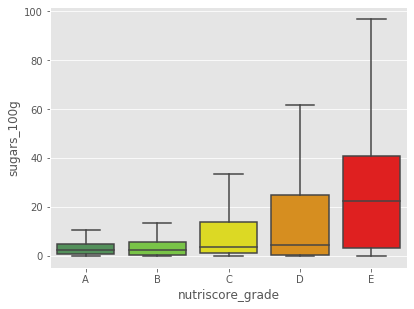

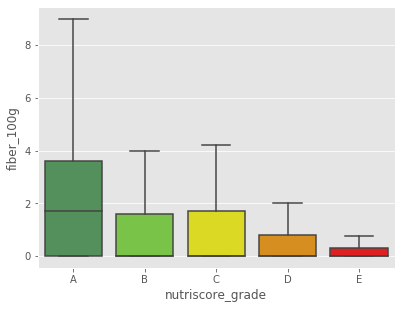

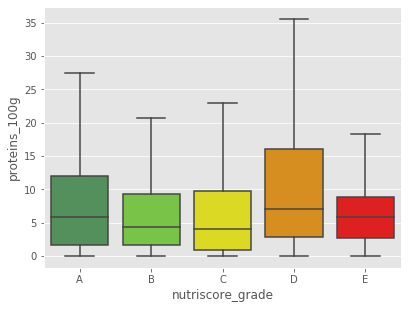

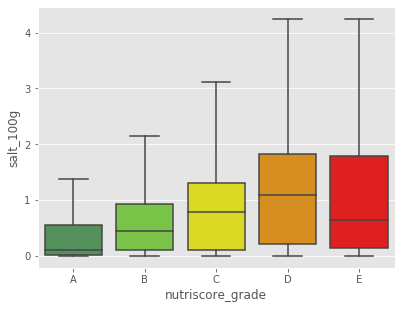

In [16]:
data_for_plot = df[macro_nutriments_labels + ["nutriscore_grade"]].dropna(subset=["nutriscore_grade"])
order = sorted(df["nutriscore_grade"].dropna().unique())
labels = ['A', 'B', 'C', 'D', 'E']
y_pos = np.arange(len(labels))
for macro_nutri in macro_nutriments_labels :
    sns.boxplot(data=data_for_plot, x='nutriscore_grade', y=macro_nutri, order=order, showfliers=False, palette={'a':"#499A53", 'b':"#74D834", 'c':"#FBF605", 'd':"#F49402", 'e':"#FF0000"})
    plt.xticks(y_pos, labels)
    plt.show()


- The more sugar, fat and salt in a product, the worse its Nutri-Score is.
- The higher the fibre content of a food, the lower the likelihood of poor nutritional quality.

### 2.4 Statistical Test : ANOVA Test 

##### Question
Is there a significant difference in protein value between the different grades of nutriscore?

##### Hypothesis formulation
H0 = There is equality between the nutriscore grades.
H1 = At least 1 grade is significantly different.

##### Choice of test
We have a quantitative variable and a qualitative variable with 5 modalities. We realize an anova.

In [17]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
data_lm = df[["nutriscore_grade", "proteins_100g"]].dropna(subset = ["nutriscore_grade"])
lm = ols('proteins_100g ~ C(nutriscore_grade)',data=data_lm).fit()
table = sm.stats.anova_lm(lm)
print(table)

                           df        sum_sq        mean_sq            F  \
C(nutriscore_grade)       4.0  9.898353e+05  247458.823274  3410.399548   
Residual             536473.0  3.892652e+07      72.560068          NaN   

                     PR(>F)  
C(nutriscore_grade)     0.0  
Residual                NaN  


As the p-value is below 0.05, we reject the null hypothesis in favor of the alternative: this means that at least one group mean is significantly different.

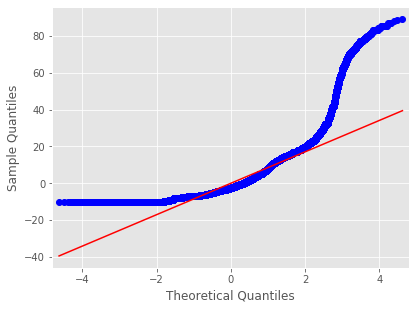

In [18]:
res = lm.resid 
fig = sm.qqplot(res, line='s')
plt.show()

### 2.5 Correlation

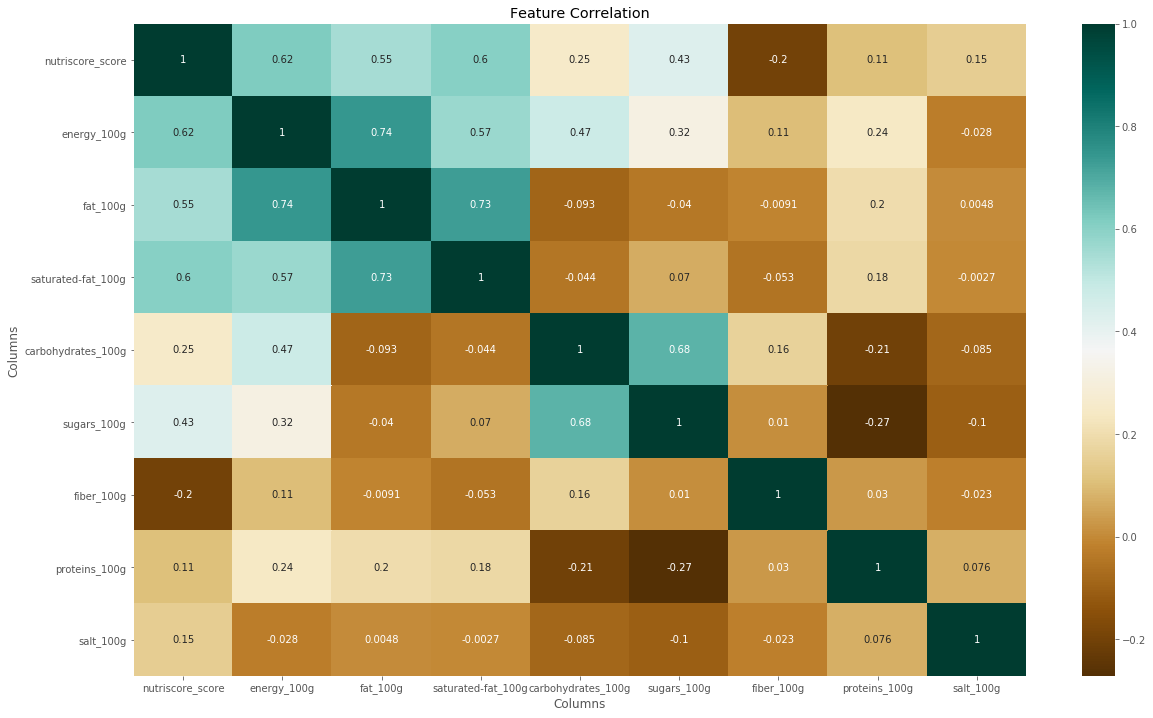

In [8]:
fig, ax = plt.subplots(figsize=(20,12))
sns.heatmap(df.corr(), annot=True, ax=ax, cmap='BrBG').set(
    title = 'Feature Correlation', xlabel = 'Columns', ylabel = 'Columns')
plt.show()


Some insights from the above correlation heatmap:

- Expected stronge correlation between fat and saturated fat and energy
- Expected stronge correlation between carbohydrates and sugars
- Correlation between nutriscore grade and saturaded fat, energy and sugar that we highlighted in the multivariate analysis
- Possible correlation between nutriscore and fiber that we highlighted in the multivariate analysis
- Possible correlation between proteins and sugar

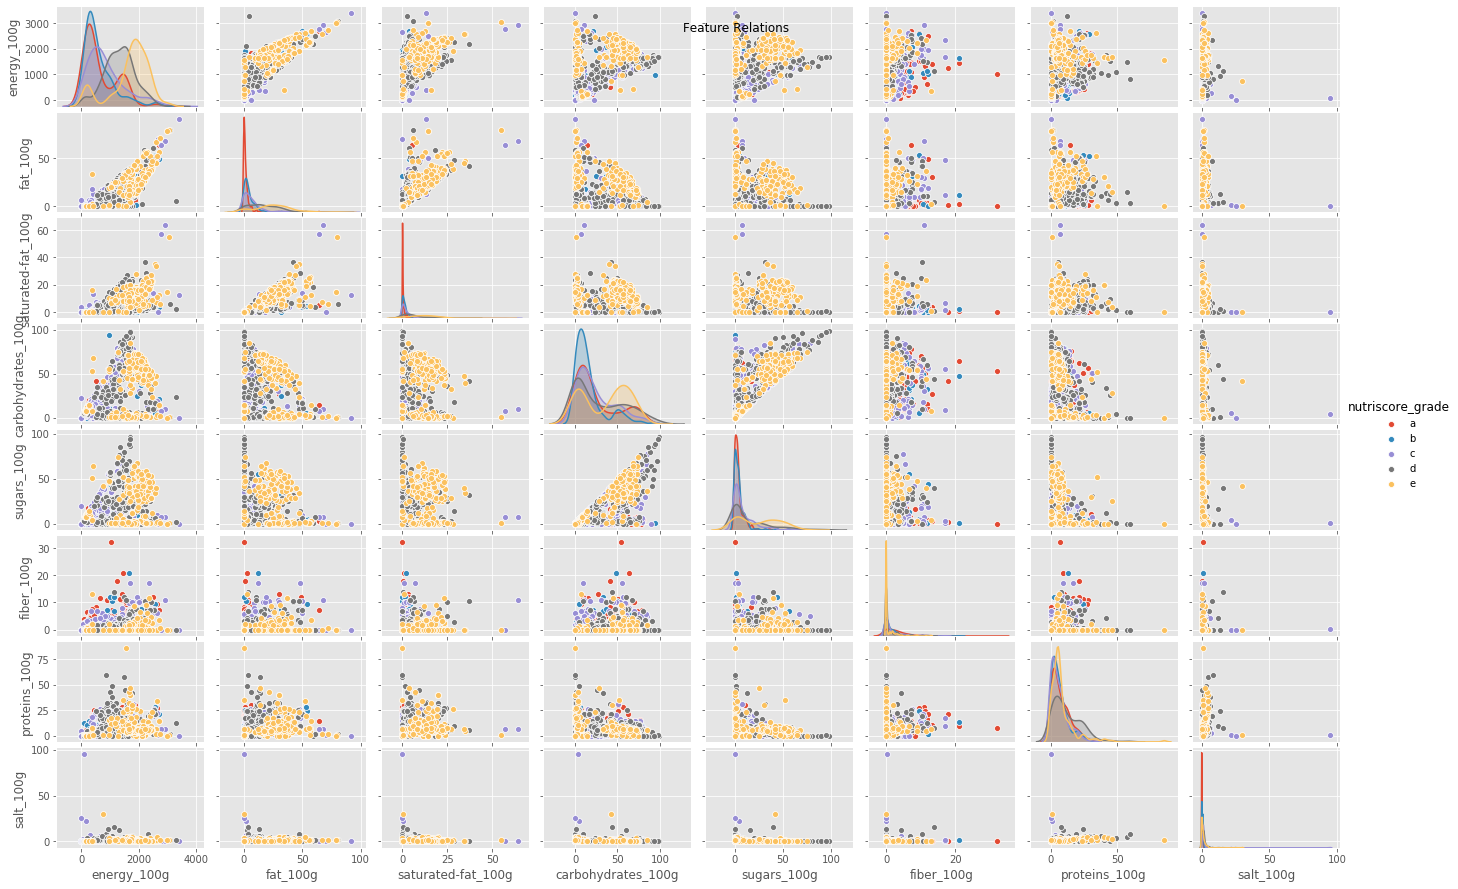

In [14]:
index = np.random.permutation(df.index)[0:2000]
g = sns.pairplot(data=df.loc[index], vars=["energy_100g", "fat_100g", "saturated-fat_100g", "carbohydrates_100g", "sugars_100g" ,"fiber_100g", "proteins_100g", "salt_100g"], hue = "nutriscore_grade")
g.fig.suptitle('Feature Relations')
g.fig.set_size_inches(20,12)
plt.show()

- The pairplot helps to distinguish a certain local grouping between products of the same Nutri-Score.
- By selecting a product and placing it it in the pairplot according to the nutrients it contains, we could obtain a prediction of its nutritional quality and therefore the Nutriscore grade to which it could belong. It may therefore be interesting to use a K-NN model during the modelization

## 3. Data Pre-Conditioning¶

In this section we will make our data ready for model training. This will include:

1. Transform 'nutriscore_grade' column into numerical values.
2. Split data set into training and testing parts (80/20), while dropping the category column (string, and not going to be used to train the models), and separating nutriscore_grade column, where it will be used as labels.
3. We will try different splits of our dataset with/without feature scaling.

##### nutriscore_grade Transform


In [16]:
df_final = df[["product_name", "nutriscore_grade", "energy_100g", "fat_100g", "saturated-fat_100g", "carbohydrates_100g", "sugars_100g", "fiber_100g", "proteins_100g", "salt_100g"]]

##### Data Split 1: all of our final dataset, no scaling

In [17]:
y = df_final['nutriscore_grade'].dropna()
X = df_final.dropna(subset = ["nutriscore_grade"]).drop(['nutriscore_grade','product_name'], axis=1)

encoder = LabelEncoder()
y = encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

##### Data Split 2: all of our final dataset,  scaling

In [20]:
sc_X = StandardScaler()

X2_train = sc_X.fit_transform(X_train)
X2_test = sc_X.fit_transform(X_test)
y2_train = y_train
y2_test = y_test

## 4. Modelization
### 4.1 Cross Val Accuracy
##### K-NN

In [136]:
accuracy = {}

In [143]:
knn_clf = KNeighborsClassifier()

accuracy["knn"] = cross_val_score(knn_clf, X_train, y_train, cv=10)
print('KNN:')
print('\nall features, No scaling:')
print("Accuracy for a k-NN on validation dataset : {:.2f} %".format(100*accuracy["knn"].mean()))

KNN:

all features, No scaling:
Accuracy for a k-NN on validation dataset : 76.56 %


In [144]:
knn_clf2 = KNeighborsClassifier()

accuracy["knn2"] = cross_val_score(knn_clf2, X2_train, y2_train, cv=10)
print('KNN:')
print('\nall features, With scaling:')
print("Accuracy for a k-NN on validation dataset : {:.2f} %".format(100*accuracy["knn2"].mean()))

KNN:

all features, With scaling:
Accuracy for a k-NN on validation dataset : 86.91 %


##### Random Forest


In [146]:
forest_clf = RandomForestClassifier(n_estimators=30, random_state=101)

accuracy["random_forest"] = cross_val_score(forest_clf, X_train, y_train, cv=10)
print('Random Forest:')
print('\nall features, No scaling:')
print("Accuracy for a Random Forest Algorithm on validation dataset : {:.2f} %".format(100*accuracy["random_forest"].mean()))

Random Forest:

all features, No scaling:
Accuracy for a Random Forest Algorithm on validation dataset : 92.03 %


In [137]:
forest_clf2 = RandomForestClassifier(n_estimators=30, random_state=101)

accuracy["random_forest2"] = cross_val_score(forest_clf2, X2_train, y2_train, cv=10)
print('Random Forest:')
print('\nall features, With scaling:')
print("Accuracy for a Random Forest Algorithm on validation dataset : {:.2f} %".format(100*accuracy["random_forest2"].mean()))

Random Forest:

all features, With scaling:
Accuracy for a Random Forest Algorithm on validation dataset : 92.04 %


##### Model Selection

In [29]:
print("The performance of the k-nn model is around : {:.2f} % +- {:.2f} %".format(100*accuracy["knn2"].mean(), 100*accuracy["knn2"].std()))
print("The performance of the Random Forest model is around : {:.2f} % +- {:.2f} %".format(100*accuracy["random_forest"].mean(), 100*accuracy["random_forest"].std()))

The performance of the k-nn model is around : 86.91 % +- 0.21 %
The performance of the Random Forest model is around : 92.03 % +- 0.12 %


##### Optimization
We will use grid search in order to obtain good parameters for our RF regressor. Of course our optimization here will be limited due to time and computing power constraints. The parameters we will optimiz are:

- n-estimators
- min_samples_leaf
- max_depth
- max_features
- bootstrap

In [87]:
rf_param_grid = {'bootstrap': [True],
    'max_depth': [60, 80, 100],
    'max_features': [4, 6, 8],
    'min_samples_leaf': [3, 4, 5],
    'n_estimators': [50, 80, 120]}

In [88]:
rf_grid = GridSearchCV(estimator= RandomForestClassifier(), param_grid = rf_param_grid,  n_jobs=-1, verbose=0)

In [89]:
rf_grid.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [90]:
rf_grid.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 6,
 'min_samples_leaf': 3,
 'n_estimators': 120}

In [91]:
rf_opti = rf_grid.best_estimator_
rf_opti

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=80, max_features=6,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=120,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [135]:
rf_grid_predictions = rf_opti.predict(X_test)

In [142]:
accuracy_grid = metrics.accuracy_score(y_test, rf_grid_predictions)
accuracy_base = accuracy["random_forest2"].mean()
print("Random Forest Performance with Tuning of Hyperparameters")
print("Accuracy:",metrics.accuracy_score(y_test, rf_grid_predictions))
improvement_baseline = 100 * abs(accuracy_grid - accuracy_base) / accuracy_base
print('Improvement over baseline:', round(improvement_baseline, 2), '%.')


Random Forest Performance with Tuning of Hyperparameters
Accuracy: 0.9301465105875335
Improvement over baseline: 1.05 %.


With the tuning of the hyperparameters we improved the accuracy by around 1%

### 4.3 Performance and Error Analysis
##### Confusion Matrix

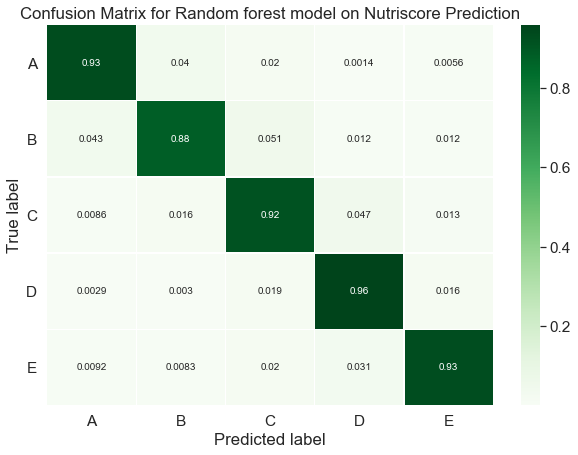

In [94]:
from sklearn.metrics import confusion_matrix

# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, rf_grid_predictions)
matrix = matrix.astype('float') / matrix.sum(axis=1) [:, np.newaxis]

# Build the plot
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['A', 'B', 'C', 'D', 'E']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks2, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random forest model on Nutriscore Prediction')
plt.show()

##### Classification Report

In [95]:
from sklearn.metrics import classification_report
print(classification_report(y_test, rf_grid_predictions))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94     17752
           1       0.91      0.88      0.89     14498
           2       0.91      0.92      0.91     22316
           3       0.94      0.96      0.95     32986
           4       0.94      0.93      0.94     19744

    accuracy                           0.93    107296
   macro avg       0.93      0.92      0.93    107296
weighted avg       0.93      0.93      0.93    107296



##### Model/Reality Gap

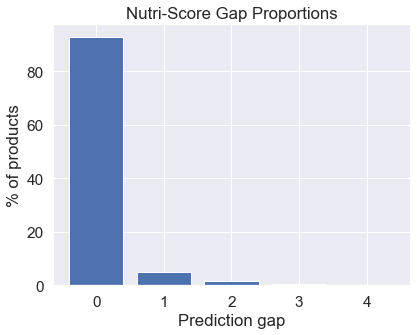

In [96]:
ecart = [list(abs(y_test - rf_grid_predictions)).count(k)/len(y_test)*100 for k in range(5)]
plt.bar(height = ecart, x =range(5))
plt.xlabel("Prediction gap")
plt.ylabel("% of products")
plt.title("Nutri-Score Gap Proportions")
plt.show()

##### Prediction exemple

In [97]:
X_na = df_final[df_final.nutriscore_grade.isna()].drop(['nutriscore_grade','product_name'], axis=1)
y_na = rf_opti.predict(X_na)
y_na = encoder.inverse_transform(y_na)

In [98]:
df_final["nutriscore_grade"][df_final["nutriscore_grade"].isna()] = y_na

In [99]:
df_final.head(10)

,product_name,nutriscore_grade,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
0,vitória crackers,d,1569.0,7.0,3.08,70.1,15.0,0.0,7.8,1.400
1,moutarde au moût de raisin,d,936.0,8.2,2.20,29.0,22.0,0.0,5.1,4.600
2,sauce sweety chili 0%,c,88.0,0.0,0.00,4.8,0.4,0.0,0.2,2.040
3,mini coco,c,251.0,3.0,1.00,10.0,3.0,0.0,2.0,1.150
4,salade de carottes râpées,b,134.0,0.3,0.10,5.3,3.9,0.0,0.9,0.420
5,fromage blanc aux myrtilles,c,540.0,4.9,3.10,16.3,16.3,0.0,4.4,0.250
6,baguette parisien,b,929.0,3.3,2.10,38.4,1.8,0.0,11.7,0.678
7,chocolate n 3,e,2439.0,44.0,28.00,30.0,27.0,0.0,2.1,0.020
8,&quot;baguette lyonnais&quot;,c,1213.0,9.4,4.50,41.0,2.0,0.0,12.5,0.900
9,solène céréales poulet,a,916.0,5.9,0.50,30.3,1.7,2.8,9.7,0.464


##### Proportion of nutriscore in dataset products before and after predicton

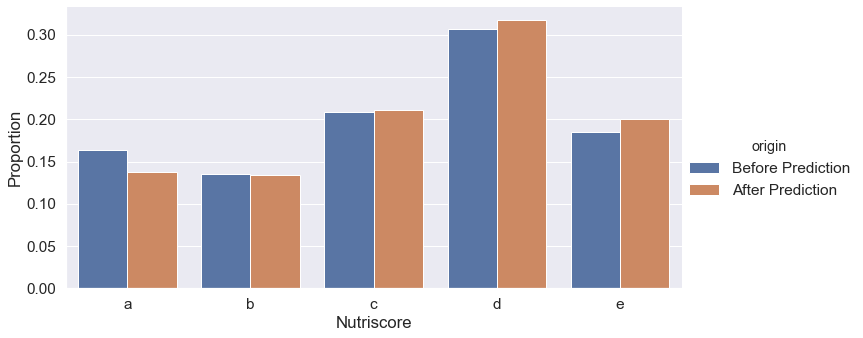

In [100]:
df_before_prediction = df["nutriscore_grade"].value_counts(normalize=True).rename_axis('Nutriscore').reset_index(name='Proportion')
df_before_prediction["origin"]="Before Prediction"
df_after_prediction = df_final["nutriscore_grade"].value_counts(normalize=True).rename_axis('Nutriscore').reset_index(name='Proportion')
df_after_prediction["origin"]="After Prediction"

df_comparison = pd.concat([df_before_prediction, df_after_prediction], axis=0, ignore_index=False)
df_comparison.reset_index(inplace=True)

sns.catplot(x='Nutriscore', y='Proportion', hue='origin', kind='bar', data=df_comparison, height=5, aspect=2) 

### 4.4 Features Importance

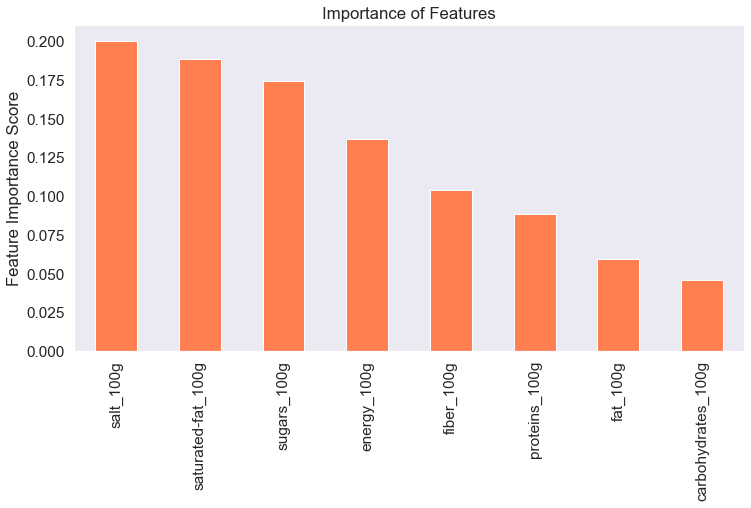

In [101]:
feat_imp = pd.Series(rf_grid.best_estimator_.feature_importances_, list(X_train)).sort_values(ascending=False)
fig = plt.figure(figsize=(12, 6))
feat_imp.plot(kind='bar', title='Importance of Features', color= 'coral')
plt.ylabel('Feature Importance Score')
plt.grid()
plt.show()

## 5. Conclusion

In this project, we used the Open Food Fact dataset to build a nutriscore grade predictor. 2 different learning classifier (K-NN and Random Forest) were tested, and we have acheived the best prediction performance using Random Forest.

The best prediction performance was acheived using Random Forest regressor, using all features in the dataset and without scaling, and resulted in the following metrics on a weight average:

- Precision : 0.93
- Recall : 0.93
- F1-score : 0.93